In [1]:
import numpy as np
import pandas as pd
from scipy import spatial
import volpriceinference as vl
import matplotlib as mpl
import seaborn as sns
import logging
import tqdm
from multiprocessing import Pool
import sys

In [2]:
%matplotlib inline
mpl.style.use('seaborn-talk')
np.set_printoptions(precision=3)

In [3]:
logging.captureWarnings(True)
root_logger = logging.getLogger()
root_logger.setLevel(logging.INFO)
info_handler = logging.FileHandler('../logging.tmp.txt')
info_handler.addFilter(lambda record: record.levelno <= logging.WARNING)
error_handler = logging.StreamHandler(sys.stderr)
error_handler.addFilter(lambda record: record.levelno > logging.WARNING)
root_logger.addHandler(info_handler)
root_logger.addHandler(error_handler)

In [4]:
vl.__version__

'0.0.17-py37_1'

In [5]:
innov_dim = 2000

## Load the data

In [6]:
with pd.HDFStore('../data/spy_daily_estimates_2003-2017_1000_1sec.hdf') as store:
    daily_rtn = store['daily_rtn'] * 252
    vol = store['discrete_vol_est'] * 252**2 
    
    data = pd.concat([daily_rtn, vol.diffusion + vol.jumps], axis=1).dropna()
    data.columns = ['rtn', 'vol']

In [7]:
data.head()

,rtn,vol
2003-01-02,6.419615,8.799756
2003-01-03,0.539956,7.785992
2003-01-06,5.150512,4.586335
2003-01-07,-0.896750,8.294531
2003-01-08,-2.748119,6.446751


In [8]:
data.transform(lambda x: np.sqrt(x) if x.name == 'vol' else x).cov()

,rtn,vol
rtn,5.523276,-0.229847
vol,-0.229847,1.886587


In [9]:
data.corr()

,rtn,vol
rtn,1.000000,-0.024379
vol,-0.024379,1.000000


In [10]:
data.describe()

,rtn,vol
count,3713.000000,3713.000000
mean,0.023421,5.621287
std,2.350165,14.458447
min,-20.781833,0.123335
25%,-0.954041,1.380618
50%,0.128299,2.416002
75%,1.099523,5.030940
max,18.031014,421.880784


In [14]:
data.describe()

,rtn,vol
count,3713.000000,3713.000000
mean,0.023421,5.621287
std,2.350165,14.458447
min,-20.781833,0.123335
25%,-0.954041,1.380618
50%,0.128299,2.416002
75%,1.099523,5.030940
max,18.031014,421.880784


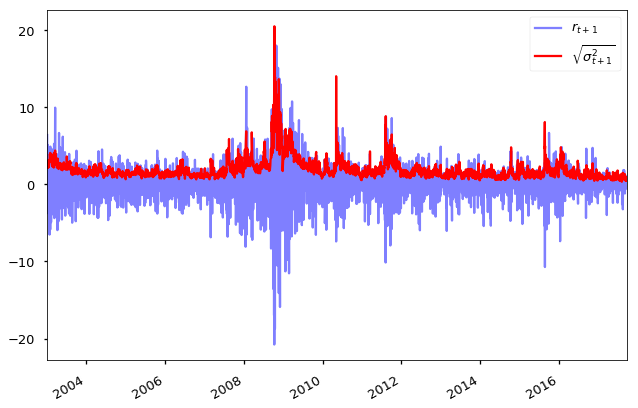

In [12]:
fig1, ax1 = mpl.pyplot.subplots()
data['rtn'].plot(ax=ax1, color='blue', alpha=.5, label="$r_{t+1}$")
data['vol'].apply(np.sqrt).plot(ax=ax1, label='$\sqrt{\sigma^2_{t+1}}$', color='red')
ax1.legend()
fig1.savefig('../doc/figures/time_series.tmp.pdf', frameon=False, pad_inches=0, bbox_inches='tight',
            transparent=True)

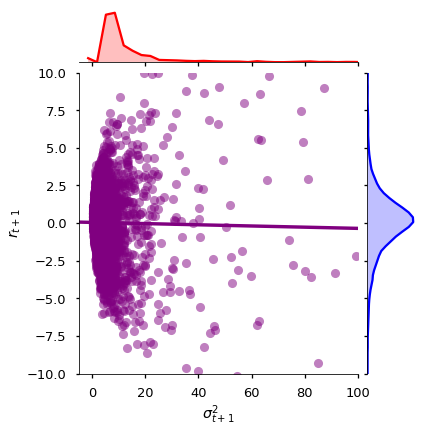

In [15]:
joint_grid = sns.JointGrid(x='vol', y='rtn', data=data, xlim=[-5, 100], ylim=[-10, 10])
joint_grid.plot_joint(sns.regplot, ci=None, color='purple', scatter_kws={"alpha":.5})
sns.kdeplot(data['vol'], ax=joint_grid.ax_marg_x, legend=None, shade=True, color='red')
sns.kdeplot(data['rtn'], ax=joint_grid.ax_marg_y, legend=None, shade=True, color='blue', vertical=True)
joint_grid.set_axis_labels("$\sigma^2_{t+1}$","$r_{t+1}$")
joint_grid.savefig('../doc/figures/joint_dist.tmp.pdf', frameon=False, pad_inches=0, bbox_inches='tight',
            transparent=True)

In [16]:
omega, omega_cov = vl.estimate_params_strong_id(data)

In [17]:
vl.compute_init_constants(data.vol)

{'log_both': 0.37463265375235344,
 'log_scale': 2.265603174187479,
 'rho': 0.7409169043125318}

In [18]:
vl.compute_vol_gmm(data.vol, vl.compute_init_constants(data.vol))

({'log_both': 0.9068982998540172,
  'log_scale': 1.8030412407446503,
  'rho': 0.5170973517357483},
            log_both  log_scale       rho
 log_both   0.045039   0.039444 -0.023642
 log_scale  0.039444   0.081291 -0.017686
 rho       -0.023642  -0.017686  0.012850)

In [19]:
estimates, covariance = vl.estimate_params(data, *vl.compute_vol_gmm(data.vol, 
                                                                     vl.compute_init_constants(data.vol))) 
                                           


In [20]:
estimates

{'gamma': 0.25965685942691796,
 'beta': 0.1113552770767416,
 'psi': -0.15373902507632284,
 'zeta': 0.9086856628806307,
 'log_both': 0.9068982998540172,
 'log_scale': 1.8030412407446503,
 'rho': 0.5170973517357483}

In [21]:
vl.compute_strong_id(estimates, covariance)

({'phi': -0.29093720869824036,
  'pi': -2.8982376910040834e-10,
  'theta': 0.42793546199859617},
        phi  pi  theta
 phi    NaN NaN    NaN
 pi     NaN NaN    NaN
 theta  NaN NaN    NaN)

In [22]:
np.exp(1.8030412407446503)

6.068073904189804

In [23]:
strong_id_results = vl.estimate_params_strong_id(data) #,  bounds=[(-3, 2), (-1, 3), (0,1)])

In [24]:
strong_id_results

({'gamma': 0.25965685942691796,
  'beta': 0.1113552770767416,
  'psi': -0.15373902507632284,
  'zeta': 0.9086856628806307,
  'log_both': 0.9068982998540172,
  'log_scale': 1.8030412407446503,
  'rho': 0.5170973517357483,
  'phi': -0.29093720869824036,
  'pi': -2.8982376910040834e-10,
  'theta': 0.42793546199859617},
                beta     gamma  log_both  log_scale  phi  pi       psi  \
 beta       0.000097 -0.000035  0.000000   0.000000  NaN NaN -0.000091   
 gamma     -0.000035  0.000648  0.000000   0.000000  NaN NaN -0.000080   
 log_both   0.000000  0.000000  0.045039   0.039444  NaN NaN  0.000000   
 log_scale  0.000000  0.000000  0.039444   0.081291  NaN NaN  0.000000   
 phi             NaN       NaN       NaN        NaN  NaN NaN       NaN   
 pi              NaN       NaN       NaN        NaN  NaN NaN       NaN   
 psi       -0.000091 -0.000080  0.000000   0.000000  NaN NaN  0.000149   
 rho        0.000000  0.000000 -0.023642  -0.017686  NaN NaN  0.000000   
 theta          

In [25]:
# Since log_delta = log_both - log_scale. Asy Var(hat{log_delta}) = var(log_both) + var(log_both)
# - 2 * cov(log_both, log_scale)

In [26]:
omega

{'gamma': 0.25965685942691796,
 'beta': 0.1113552770767416,
 'psi': -0.15373902507632284,
 'zeta': 0.9086856628806307,
 'log_both': 0.9068982998540172,
 'log_scale': 1.8030412407446503,
 'rho': 0.5170973517357483,
 'phi': -0.29093720869824036,
 'pi': -2.8982376910040834e-10,
 'theta': 0.42793546199859617}

In [27]:
pd.Series(omega)

gamma        2.596569e-01
beta         1.113553e-01
psi         -1.537390e-01
zeta         9.086857e-01
log_both     9.068983e-01
log_scale    1.803041e+00
rho          5.170974e-01
phi         -2.909372e-01
pi          -2.898238e-10
theta        4.279355e-01
dtype: float64

In [28]:
omega_cov

,beta,gamma,log_both,log_scale,phi,pi,psi,rho,theta,zeta
beta,0.000097,-0.000035,0.000000,0.000000,NaN,NaN,-0.000091,0.000000,NaN,0.000000
gamma,-0.000035,0.000648,0.000000,0.000000,NaN,NaN,-0.000080,0.000000,NaN,0.000000
log_both,0.000000,0.000000,0.045039,0.039444,NaN,NaN,0.000000,-0.023642,NaN,0.000000
log_scale,0.000000,0.000000,0.039444,0.081291,NaN,NaN,0.000000,-0.017686,NaN,0.000000
phi,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
pi,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
psi,-0.000091,-0.000080,0.000000,0.000000,NaN,NaN,0.000149,0.000000,NaN,0.000000
rho,0.000000,0.000000,-0.023642,-0.017686,NaN,NaN,0.000000,0.012850,NaN,0.000000
theta,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
zeta,0.000000,0.000000,0.000000,0.000000,NaN,NaN,0.000000,0.000000,NaN,0.000431


In [29]:
data.vol.sort_values(ascending=True).head()

2017-08-07    0.123335
2017-09-14    0.214673
2017-09-22    0.216867
2016-11-25    0.226227
2017-07-24    0.242692
Name: vol, dtype: float64

In [30]:
omega2, omega_cov2 = vl.estimate_params(data)

In [31]:
omega2

{'gamma': 0.25965685942691796,
 'beta': 0.1113552770767416,
 'psi': -0.15373902507632284,
 'zeta': 0.9086856628806307,
 'log_both': 0.9068982998540172,
 'log_scale': 1.8030412407446503,
 'rho': 0.5170973517357483}

In [32]:
qlr_stats = vl.compute_qlr_stats(omega=omega2, omega_cov=omega_cov2, theta_dim=10, pi_dim=10, phi_dim=10, 
                                 pi_min=-.25, pi_max=0, theta_min=.2, theta_max=.6,  use_tqdm=True)
                               


In [ ]:
qlr_draws = vl.compute_qlr_sim(omega=omega2, omega_cov=omega_cov2, theta_dim=10, pi_dim=10, phi_dim=10, 
                               innov_dim=innov_dim, pi_min=-.25, pi_max=0, theta_min=.2, theta_max=.6,
                               use_tqdm=True, alpha=0.05)

In [ ]:
np.sort(qlr_stats.phi.unique()) - np.sort(qlr_draws.phi.unique())

In [ ]:
qlr_stats.set_index(['phi', 'pi', 'theta']).head()

In [ ]:
qlr_stats.count()

In [ ]:
qlr_stats.sort_values(by=['phi', 'pi', 'theta'], inplace=True)
qlr_draws.sort_values(by=['phi', 'pi', 'theta'], inplace=True)
close_enough = np.allclose(qlr_stats[['phi', 'pi', 'theta']], qlr_draws[['phi', 'pi', 'theta']])

if not close_enough:
    raise RuntimeError('The indices are not the same!!!')
    
else:
    qlr_stats[['phi', 'pi', 'theta']] = qlr_draws[['phi', 'pi', 'theta']]
    
    
merged_values = pd.merge(qlr_stats, qlr_draws,left_on=['phi', 'pi', 'theta'], right_on=['phi', 'pi', 'theta'],
                         suffixes=['_draws', '_stats'])

In [ ]:
qlr_stats.sort_values(by='qlr').head()

In [ ]:
qlr_draws.sort_values(by='qlr').head()

In [ ]:
merged_values.head()

In [ ]:
accepted_vals = merged_values.query('qlr_stats > qlr_draws').drop(['qlr_draws', 'qlr_stats'], axis='columns')

In [ ]:
qlr_draws.to_json(f'../results/qlr_draws_on_data_{innov_dim}_smaller_region.json')

In [ ]:
qlr_draws = pd.read_json(f'../results/qlr_draws_on_data_{innov_dim}_smaller_region.json')

In [ ]:
def constraint(scale, psi, zeta, equity_price):
    
    vol_price  = -1 / scale - ((psi * (equity_price-1) + zeta/2 * (equity_price-1)**2))
    
    return  vol_price

In [ ]:
accepted_vals

In [ ]:
omega

In [ ]:
fig3, ax3 = mpl.pyplot.subplots()
ax3.scatter(y=accepted_vals.theta, x=accepted_vals.pi, marker='o', s=650, label='Not Rejected Values',
           color='purple')
ax3.set_xlim([-3.5, .5])
ax3.set_ylim([-.5, 3.5])
yvals = np.linspace(0,1,100)
# xvals = [constraint(np.exp(omega['log_scale']), omega['psi'], omega['zeta'], x) for x in yvals]
# ax3.plot(xvals, yvals, color='black', label='Constraint')
ax3.axvline(0,  ymin=.5 /6, ymax=1 - .5/6, color='black')
ax3.axhline(0,  xmin=.915, xmax=0, color='black')

white_rect = mpl.patches.Rectangle((0,0), .1, 1, angle=0.0, color='white', fill=True)
ax3.add_patch(white_rect)

ax3.set_ylabel(r'$\theta$')
ax3.set_xlabel(r'$\pi$')
ax3.set_ylim([-0.1, 1.1])
ax3.set_xlim([-1.1, 0.1])
ax3.legend(loc='upper left')

fig3.savefig('../doc/figures/confidence_region_2.tmp.pdf', frameon=False, pad_inches=0, bbox_inches='tight',
            transparent=True)

In [ ]:
accepted_vals.min()

In [ ]:
accepted_vals.max()